# Package

In [68]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

In [69]:
# pip install seaborn

# Read data

In [70]:
df_masked = pd.read_csv('/users/ywan1077/data/ywan1077/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
df_49 = pd.read_excel('/users/ywan1077/data/ywan1077/citizens_data/BrownDSI_Final_Capstone_Data_Dict.xlsx_20250401031549')
df_53 = pd.read_excel('/users/ywan1077/data/ywan1077/citizens_data/BrownDSI_Final_Capstone_Data_Dict.xlsx_20250401031453')

## data

In [71]:
df_masked.head()
print(df_masked.shape)

(17765, 49)


In [72]:
df_masked_missing_counts = df_masked.isnull().sum()

variables_with_missing = df_masked_missing_counts[df_masked_missing_counts > 0]

variables_with_missing_count = len(variables_with_missing)
variables_with_missing_count, variables_with_missing


(29,
 bucket_days_since_open       27
 rdis                      12492
 prevtran1                  4387
 prevtran2                  6613
 prevtran3                  8087
 prevtran4                  9111
 prevtran5                 10029
 prevtran6                 10737
 prevtran7                 11341
 prevtran8                 11901
 prevtran9                 12376
 prevtran10                12769
 prevtrandate1              4387
 prevtrandate2              6613
 prevtrandate3              8087
 prevtrandate4              9111
 prevtrandate5             10029
 prevtrandate6             10737
 prevtrandate7             11341
 prevtrandate8             11901
 prevtrandate9             12376
 prevtrandate10            12769
 drawee_sum                12236
 drawee_cnt                12236
 drawee_avg                12236
 drawee_max                12236
 drawee_min                12236
 RDI_DT                    11811
 RETURN_REASON             11811
 dtype: int64)

## variable 解释

In [73]:
df_49.shape

(48, 3)

In [74]:
df_53.head()

,TYPE,Field,Definition
0,Customer & Account Info,masked_dep_acct_num,Deposit account number randomly encoded to int...
1,Customer & Account Info,masked_bank_num,Masked bank number of debitor randomly masked ...
2,Customer & Account Info,masked_account_type,Masked account type of depositor mapped to ran...
3,Customer & Account Info,masked_id,Masked unique transaction identifer mapped to ...
4,Customer & Account Info,masked_product_code,Masked citizens bank product code mapped to ra...


In [75]:
are_equal = df_49.equals(df_53)

print("✅ Two datasets are same" if are_equal else "❌ There are two different datasets")

✅ Two datasets are same


In [76]:
df = df_masked
df_descriptions = df_49

# EDA

In [77]:
df_descriptions[df_descriptions['Field'] == 'relationship_balance']['Definition']

11    This is the total balance for the customer for...
Name: Definition, dtype: object

There are 48 feactures in the data, including 

- Customer & Account Info
    - masked_dep_acct_num: Deposit account number randomly encoded to integers (between 0 and 24,690)
    - masked_bank_num: Masked bank number of debitor randomly masked to integer values between 0 and 7. there are 7 types, the most is 0
    - masked_account_type: Masked account type of depositor mapped to random values of [0, 1, 2, 3, 4]. there are 5 account types. Assume checking/saving/...
    - masked_id: another unique value but different with acct_num.
    - masked_product_code: Masked citizens bank product code mapped to random integer values between 0 and 23.
    - bucket_days_since_open: Bucketed number of days since the account was open: ranges are ["0-1000", '1000-2000', '2000-5000', '5000+']
   - **number_of_owners**: observed that some records have number_of_owners equal to 0, which is logically inconsistent with standard banking operations.


- Transaction Info
    - total_deposit_amount: Total amount deposited, Log scale need
    - item_amt: Amount of a particular transaction. Amount of deposited item
    - deposit_dt: 2024-02-07 to 2024-11-29. Date of deposit.
    - channel: Channel of deposit. The channel has only one channel, “TELLER”. CAN BE delete
    - **relationship_balance**: The average value is negative, which indicates the presence of a significant number of negative entries, and some of them may have large magnitudes. The minimum value is -100 million, which is clearly an outlier or may point to a potential accounting issue.
    - oao_flg: Most accounts  are not open in the online. This flag indicates if the account was originated through the digital channel.
    - onus_ind: Most are not on us bank checks. Indicator for if the check is on us
    - treasury_check_ind: Most are not. Indicates if the maker of the check is Citizens (i.e.,the payeer is a Citizens acct.)
    - heloc_ind: Most are not. Indicates if this is HELOC check. home equity line of credit accounts (HELOC)


- Summary Vars
    - rdis: This is the total number of return deposits items for the account.
    - max_deposit_amount30d: Maximum deposit over the past 30 days
    - total_deposit_item_count: Total number of deposit items in the account's history
    - prevtran1 - prevtran10:  Amount of Xth previous transaction prior to current deposit
    - prevtrandate1 - prevtrandate10: Date of Xth previous transaction prior to current deposit
    - drawee_sum: This is the total $ deposited into the account from the payeer in the previous month.
    - drawee_cnt: This is the total volume deposited into the account from the payeer in the previous month
    - drawee_avg: This is the avg item $ deposited into the account from the payeer in the previous month
    - drawee_max: This is the max item $ deposited into the account from the payeer in the previous month
    - drawee_min: This is the min item $ deposited into the account from the payeer in the previous month

- Target Info
    - RDI_DT: This is the min item $ deposited into the account from the payeer in the previous month
    - RETURN_REASON: The return reason. This provides context to target.
    - return_target: This is the target for this study.
    - over_draft_amount: The amount that the account is overdrafted previous day

In [78]:
df.head(5)

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,1882.21,4.0,470.5525,535.92,400.77,NaN,NaN,0,0,8
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,150.00,1.0,150.0000,150.00,150.00,NaN,NaN,0,0,4
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,11
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,NaN,0,0,5


In [79]:
print(df.dtypes) 

masked_dep_acct_num           int64
masked_bank_num               int64
masked_account_type           int64
masked_id                     int64
masked_product_code           int64
bucket_days_since_open       object
number_of_owners              int64
total_deposit_amount        float64
item_amt                    float64
deposit_dt                   object
channel                      object
relationship_balance          int64
oao_flg                      object
onus_ind                     object
treasury_check_ind           object
heloc_ind                    object
rdis                        float64
max_deposit_amount30d       float64
total_deposit_item_count      int64
prevtran1                   float64
prevtran2                   float64
prevtran3                   float64
prevtran4                   float64
prevtran5                   float64
prevtran6                   float64
prevtran7                   float64
prevtran8                   float64
prevtran9                   

## Customer & Account Info

### masked_dep_acct_num
- Deposit account number randomly encoded to integers(masked)

In [80]:
print(df['masked_dep_acct_num'].is_unique)

True


In [81]:
print(df['masked_dep_acct_num'].dtype)
print(df['masked_dep_acct_num'].isnull().mean() * 100)
print(df['masked_dep_acct_num'].agg(['min', 'max']))

int64
0.0
min        0
max    24690
Name: masked_dep_acct_num, dtype: int64


In [82]:
df['masked_dep_acct_num']

0            0
1            2
2            3
3            4
4            7
         ...  
17760     8473
17761    13065
17762     5415
17763    16147
17764    19555
Name: masked_dep_acct_num, Length: 17765, dtype: int64

### masked_bank_num
- 

In [83]:
print(df['masked_bank_num'].dtype)
print(df['masked_bank_num'].isnull().mean() * 100)
print(df['masked_bank_num'].agg(['min', 'max']))

int64
0.0
min    0
max    7
Name: masked_bank_num, dtype: int64


masked_bank_num
0    15207
3      797
1      706
6      420
4      324
2      214
5       65
7       32
Name: count, dtype: int64


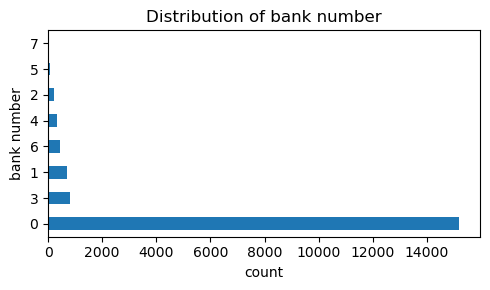

In [84]:
print(df['masked_bank_num'].value_counts())
plt.figure(figsize=(5,3))
df['masked_bank_num'].value_counts().plot.barh()
plt.xlabel('count')
plt.ylabel('bank number')
plt.title('Distribution of bank number')
plt.tight_layout()
plt.show()

In [85]:
owner_dist = df.groupby('masked_bank_num')['number_of_owners'].value_counts().unstack().fillna(0)

print(owner_dist)

number_of_owners       0       1       2      3     4    5    6    7    8
masked_bank_num                                                          
0                 1781.0  7253.0  5592.0  485.0  84.0  6.0  3.0  1.0  2.0
1                   82.0   378.0   228.0   15.0   3.0  0.0  0.0  0.0  0.0
2                    2.0   101.0   104.0    7.0   0.0  0.0  0.0  0.0  0.0
3                   40.0   495.0   236.0   21.0   5.0  0.0  0.0  0.0  0.0
4                    6.0   184.0   109.0   17.0   5.0  2.0  0.0  1.0  0.0
5                    3.0    37.0    22.0    3.0   0.0  0.0  0.0  0.0  0.0
6                   56.0   241.0   114.0    9.0   0.0  0.0  0.0  0.0  0.0
7                    2.0    24.0     6.0    0.0   0.0  0.0  0.0  0.0  0.0


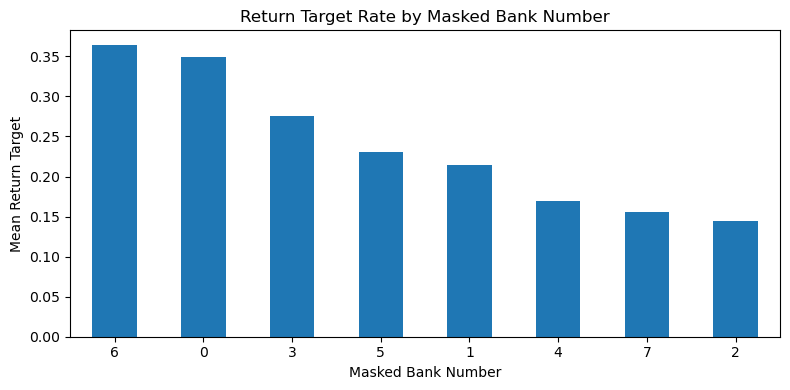

In [86]:
bank_return_rate = df.groupby('masked_bank_num')['return_target'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
bank_return_rate.plot(kind='bar')
plt.title('Return Target Rate by Masked Bank Number')
plt.xlabel('Masked Bank Number')
plt.ylabel('Mean Return Target')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [87]:
print(bank_return_rate)

masked_bank_num
6    0.364286
0    0.349313
3    0.276035
5    0.230769
1    0.213881
4    0.169753
7    0.156250
2    0.144860
Name: return_target, dtype: float64


### masked_account_type
- Masked account type of depositor mapped to random values of [0, 1, 2, 3, 4]. there are 5 account types. Assume checking/saving/...

In [88]:
print(df['masked_account_type'].dtype)
print(df['masked_account_type'].isnull().mean() * 100)
print(df['masked_account_type'].agg(['min', 'max']))

int64
0.0
min    0
max    4
Name: masked_account_type, dtype: int64


In [89]:
print(df['masked_account_type'].value_counts())

masked_account_type
0    14610
1     1733
2     1257
3      140
4       25
Name: count, dtype: int64


### masked_id

In [90]:
print(df['masked_id'].dtype)
print(df['masked_id'].isnull().mean() * 100)
print(df['masked_id'].agg(['min', 'max']))
print(df['masked_id'].is_unique)

int64
0.0
min        0
max    31651
Name: masked_id, dtype: int64
True


### masked_product_code
- Masked citizens bank product code mapped to random integer values between 0 and 23.

In [91]:
print(df['masked_product_code'].dtype)
print(df['masked_product_code'].isnull().mean() * 100)
print(df['masked_product_code'].agg(['min', 'max']))
print(df['masked_product_code'].is_unique)

int64
0.0
min     0
max    23
Name: masked_product_code, dtype: int64
False


In [92]:
df['masked_product_code'].value_counts()

masked_product_code
1     7855
0     4110
2     1182
4     1147
5     1069
6      461
7      423
9      395
8      338
12     245
15     131
11      71
17      70
13      59
10      56
19      49
21      34
16      21
18      16
20      10
14       8
22       6
3        5
23       4
Name: count, dtype: int64

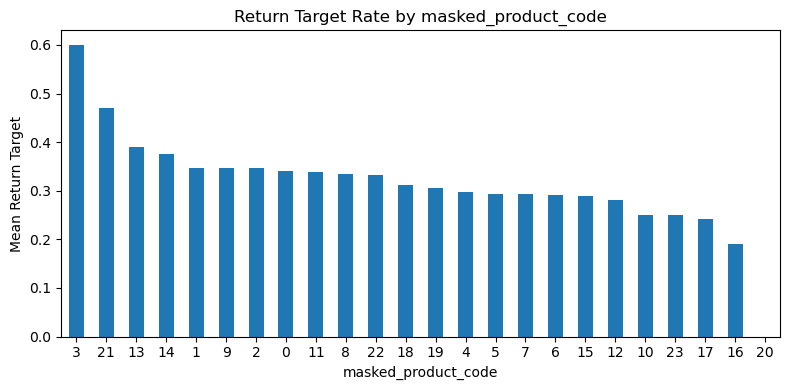

In [93]:
product_code_rate = df.groupby('masked_product_code')['return_target'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
product_code_rate.plot(kind='bar')
plt.title('Return Target Rate by masked_product_code')
plt.xlabel('masked_product_code')
plt.ylabel('Mean Return Target')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### bucket_days_since_open

In [94]:
print(df['bucket_days_since_open'].dtype)
print(df['bucket_days_since_open'].isnull().mean() * 100)
# print(df['bucket_days_since_open'].agg(['min', 'max']))
print(df['bucket_days_since_open'].is_unique)

object
0.15198423867154517
False


In [95]:
df['bucket_days_since_open'].value_counts()

bucket_days_since_open
5000+        8411
2000-5000    3949
0-1000       3674
1000-2000    1704
Name: count, dtype: int64

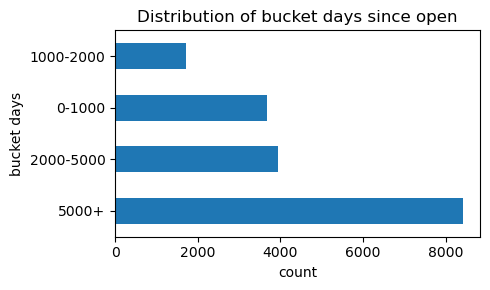

In [96]:
df['bucket_days_since_open'].value_counts()
plt.figure(figsize=(5,3))
df['bucket_days_since_open'].value_counts().plot.barh()
plt.xlabel('count')
plt.ylabel('bucket days')
plt.title('Distribution of bucket days since open')
plt.tight_layout()
plt.show()


### number_of_owners
- Number of owners in the account

In [97]:
df_53.loc[df_53['Field'] == 'number_of_owners', 'Definition']

6    Number of owners in the account
Name: Definition, dtype: object

In [98]:
print(df['number_of_owners'].dtype)
print(df['number_of_owners'].isnull().mean() * 100)
print(df['number_of_owners'].agg(['min', 'max']))
print(df['number_of_owners'].is_unique)

int64
0.0
min    0
max    8
Name: number_of_owners, dtype: int64
False


In [99]:
df['number_of_owners'].value_counts()

number_of_owners
1    8713
2    6411
0    1972
3     557
4      97
5       8
6       3
8       2
7       2
Name: count, dtype: int64

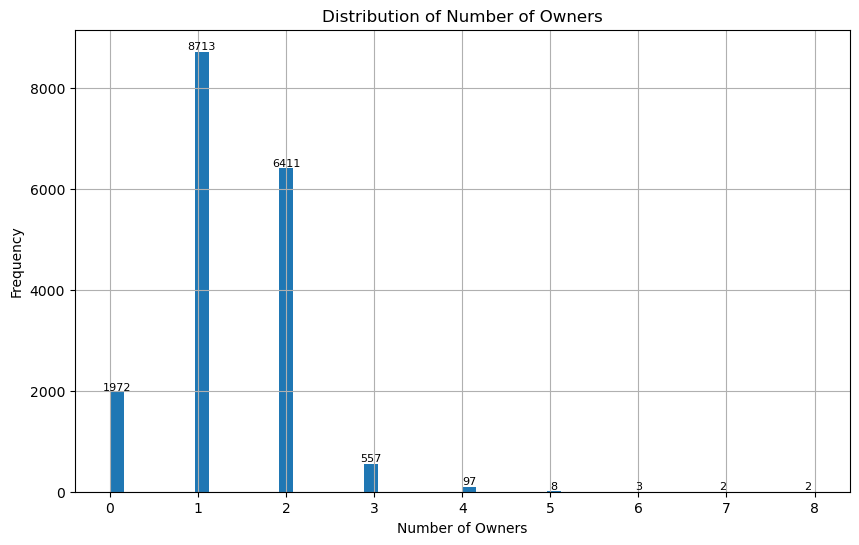

In [100]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df['number_of_owners'].dropna(), bins=50)
plt.title('Distribution of Number of Owners')
plt.xlabel('Number of Owners')
plt.ylabel('Frequency')
plt.grid(True)

for count, x, patch in zip(n, bins[:-1], patches):
    if count > 0:
        plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), 
                 ha='center', va='bottom', fontsize=8)

plt.show()

## Transaction Info

### total_deposit_amount
- Total amount deposited

In [101]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers


In [102]:
df_53.loc[df_53['Field'] == 'total_deposit_amount', 'Definition']

7    Total amount deposited
Name: Definition, dtype: object

In [103]:
print(df['total_deposit_amount'].dtype)
print(df['total_deposit_amount'].isnull().mean() * 100)
print(df['total_deposit_amount'].agg(['min', 'max']))
print(df['total_deposit_amount'].is_unique)

float64
0.0
min        100.56
max    2800000.00
Name: total_deposit_amount, dtype: float64
False


In [104]:
outliers = detect_outliers_iqr(df['total_deposit_amount'])
print(outliers)

4        10776.63
17       46332.56
23       11678.91
27       14474.09
28       10613.33
           ...   
17704    14516.80
17720    12539.58
17727    14298.61
17730    45000.00
17742     9800.00
Name: total_deposit_amount, Length: 2240, dtype: float64


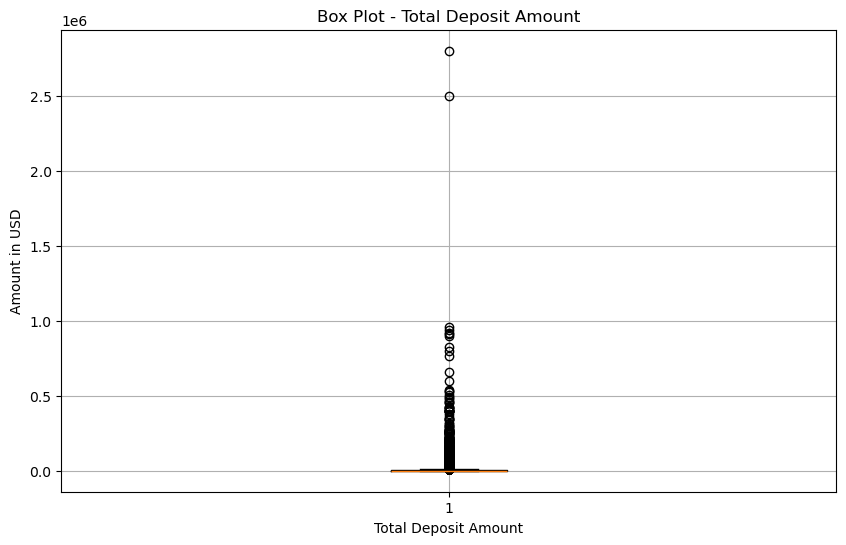

In [105]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['total_deposit_amount'].dropna())
plt.title('Box Plot - Total Deposit Amount')
plt.xlabel('Total Deposit Amount')
plt.ylabel('Amount in USD')
plt.grid(True)
plt.show()
plt.show()


In [106]:
Q1 = df['total_deposit_amount'].quantile(0.25)
Q3 = df['total_deposit_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['total_deposit_amount'] < lower_bound) | (df['total_deposit_amount'] > upper_bound)]

bank_dist = outliers['masked_bank_num'].value_counts().sort_values(ascending=False)

print(bank_dist)

masked_bank_num
0    1944
3      95
1      90
6      63
4      27
2      12
5       7
7       2
Name: count, dtype: int64


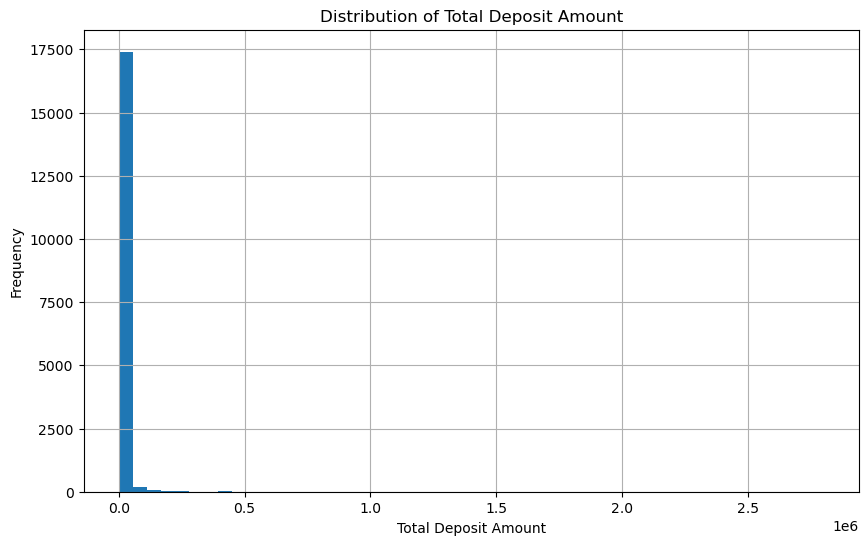

In [107]:
plt.figure(figsize=(10, 6))
plt.hist(df['total_deposit_amount'].dropna(), bins=50)
plt.title('Distribution of Total Deposit Amount')
plt.xlabel('Total Deposit Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

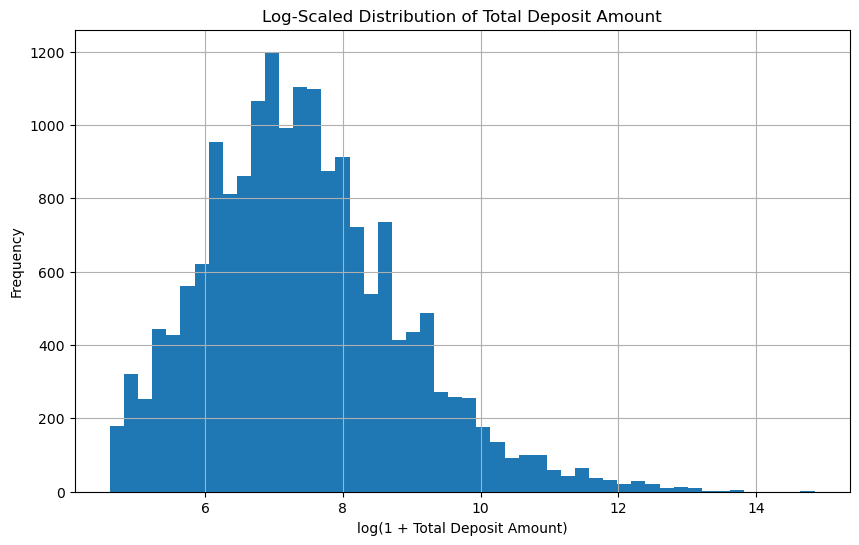

In [108]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df['total_deposit_amount'].dropna()), bins=50)
plt.title('Log-Scaled Distribution of Total Deposit Amount')
plt.xlabel('log(1 + Total Deposit Amount)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

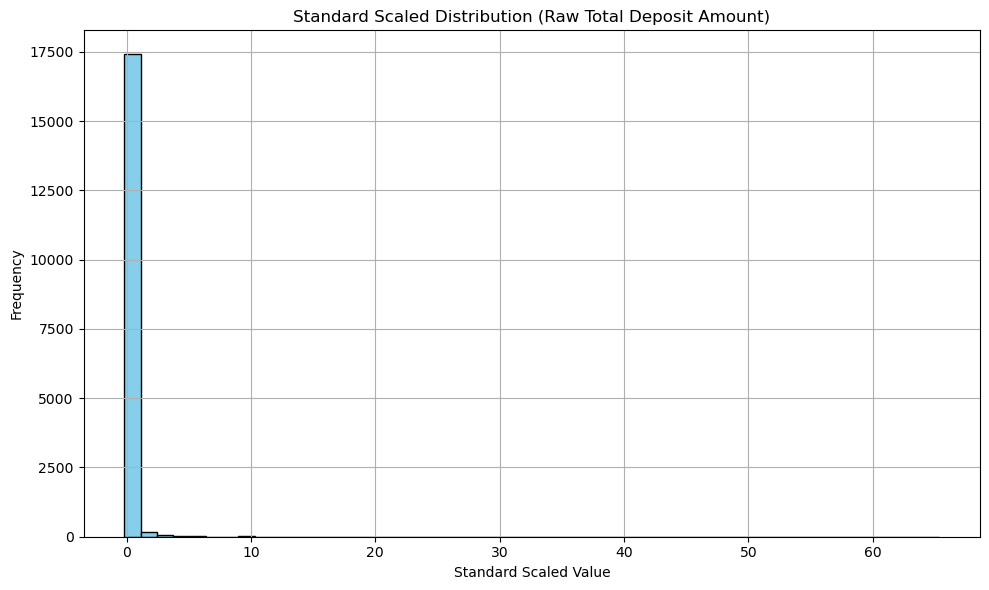

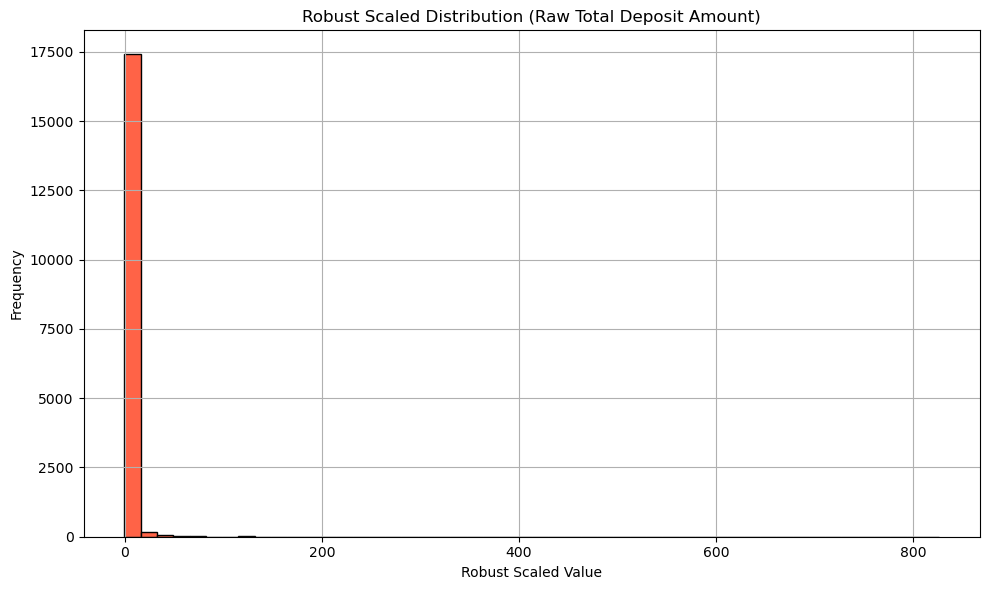

In [112]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
df['total_deposit_standard_raw'] = StandardScaler().fit_transform(df[['total_deposit_amount']])

df['total_deposit_robust_raw'] = RobustScaler().fit_transform(df[['total_deposit_amount']])

plt.figure(figsize=(10, 6))
plt.hist(df['total_deposit_standard_raw'], bins=50, color='skyblue', edgecolor='black')
plt.title('Standard Scaled Distribution (Raw Total Deposit Amount)')
plt.xlabel('Standard Scaled Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['total_deposit_robust_raw'], bins=50, color='tomato', edgecolor='black')
plt.title('Robust Scaled Distribution (Raw Total Deposit Amount)')
plt.xlabel('Robust Scaled Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


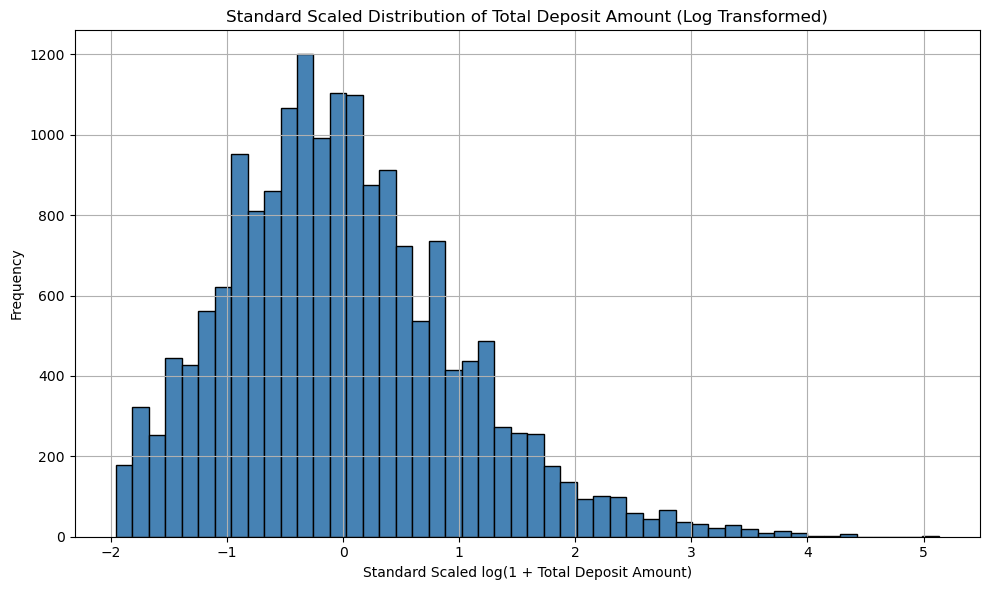

In [113]:
df['total_deposit_log'] = np.log1p(df['total_deposit_amount'])

scaler = StandardScaler()
df['total_deposit_scaled'] = scaler.fit_transform(df[['total_deposit_log']])

plt.figure(figsize=(10, 6))
plt.hist(df['total_deposit_scaled'], bins=50, color='steelblue', edgecolor='black')
plt.title('Standard Scaled Distribution of Total Deposit Amount (Log Transformed)')
plt.xlabel('Standard Scaled log(1 + Total Deposit Amount)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


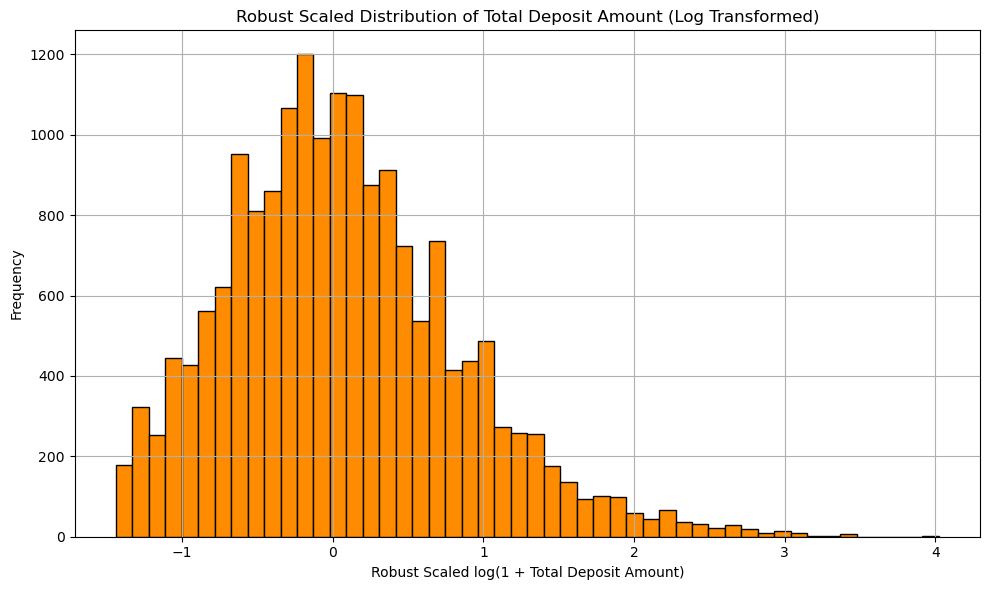

In [114]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
df['total_deposit_robust_scaled'] = robust_scaler.fit_transform(df[['total_deposit_log']])

plt.figure(figsize=(10, 6))
plt.hist(df['total_deposit_robust_scaled'], bins=50, color='darkorange', edgecolor='black')
plt.title('Robust Scaled Distribution of Total Deposit Amount (Log Transformed)')
plt.xlabel('Robust Scaled log(1 + Total Deposit Amount)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


### item_amt
- Amount of deposited item

In [ ]:
df_53.loc[df_53['Field'] == 'item_amt', 'Definition']
print(df['item_amt'].dtype)
print(df['item_amt'].isnull().mean() * 100)
print(df['item_amt'].agg(['min', 'max']))
print(df['item_amt'].is_unique)

float64
0.0
min        100.01
max    2800000.00
Name: item_amt, dtype: float64
False


In [ ]:
outliers = detect_outliers_iqr(df['item_amt'])
print(outliers)

17       46332.56
28        6500.00
34        7098.36
40        5000.00
48       48513.92
           ...   
17730    45000.00
17731     6000.00
17738     8000.00
17742     9800.00
17761     5000.00
Name: item_amt, Length: 2500, dtype: float64


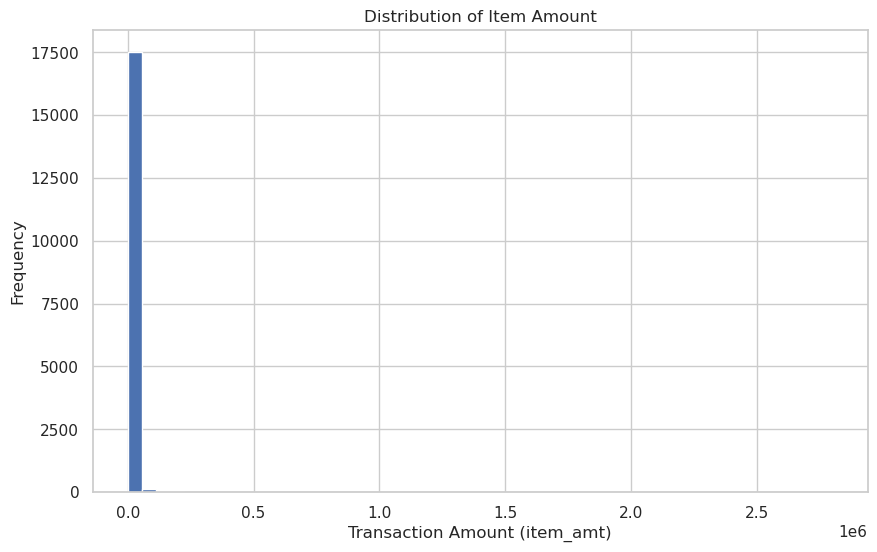

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['item_amt'].dropna(), bins=50)
plt.title('Distribution of Item Amount')
plt.xlabel('Transaction Amount (item_amt)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

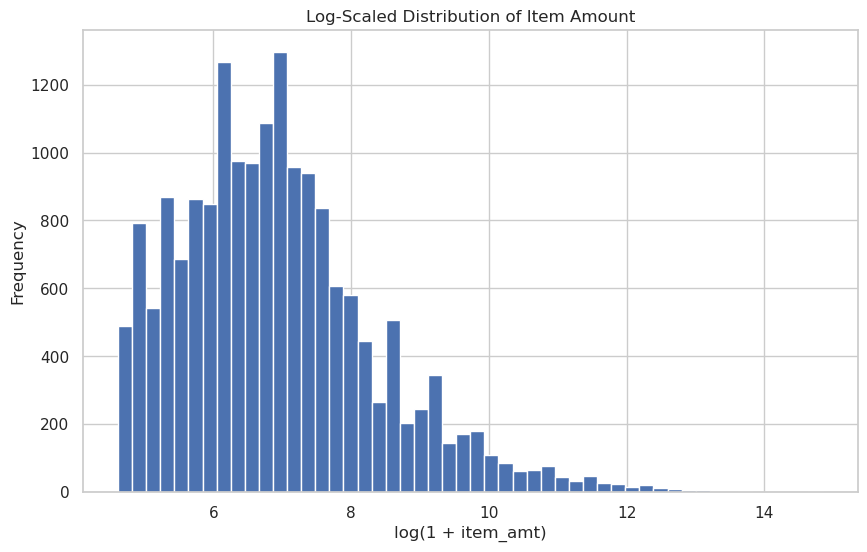

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df['item_amt'].dropna()), bins=50)
plt.title('Log-Scaled Distribution of Item Amount')
plt.xlabel('log(1 + item_amt)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### deposit_dt
- Date of deposit

In [ ]:
print(df_53.loc[df_53['Field'] == 'deposit_dt', 'Definition'])
print(df['deposit_dt'].dtype)
print(df['deposit_dt'].isnull().mean() * 100)
print(df['deposit_dt'].agg(['min', 'max']))
print(df['deposit_dt'].is_unique)

9    Date of deposit
Name: Definition, dtype: object
object
0.0
min    2024-02-07
max    2024-11-29
Name: deposit_dt, dtype: object
False


In [ ]:
df['deposit_dt'] = pd.to_datetime(df['deposit_dt'], errors='coerce')
df['deposit_dt'].min(), df['deposit_dt'].max()

(Timestamp('2024-02-07 00:00:00'), Timestamp('2024-11-29 00:00:00'))

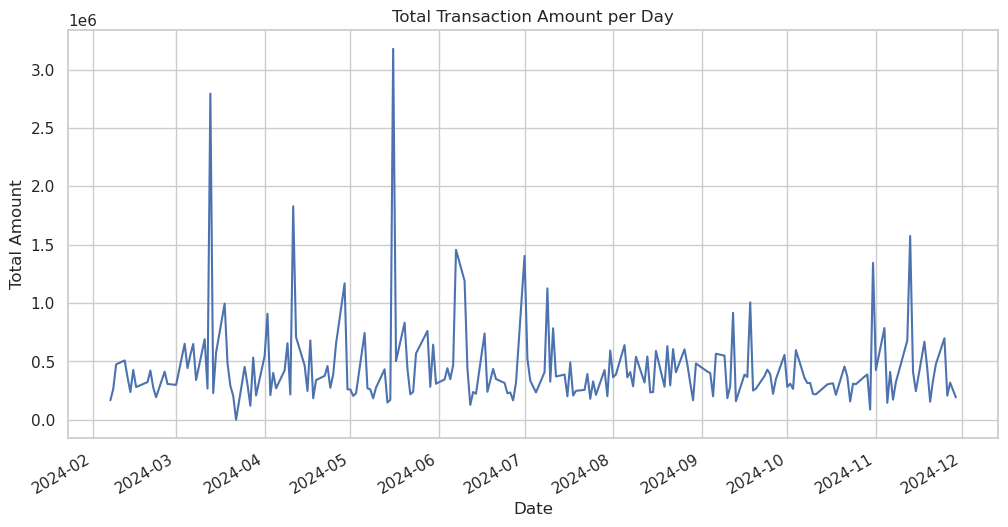

In [ ]:
daily_amt = df.groupby('deposit_dt')['item_amt'].sum()

daily_amt.plot(figsize=(12, 6))
plt.title("Total Transaction Amount per Day")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()


/tmp/ipykernel_1148981/3687841107.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_amt = df.resample('M', on='deposit_dt')['item_amt'].sum()


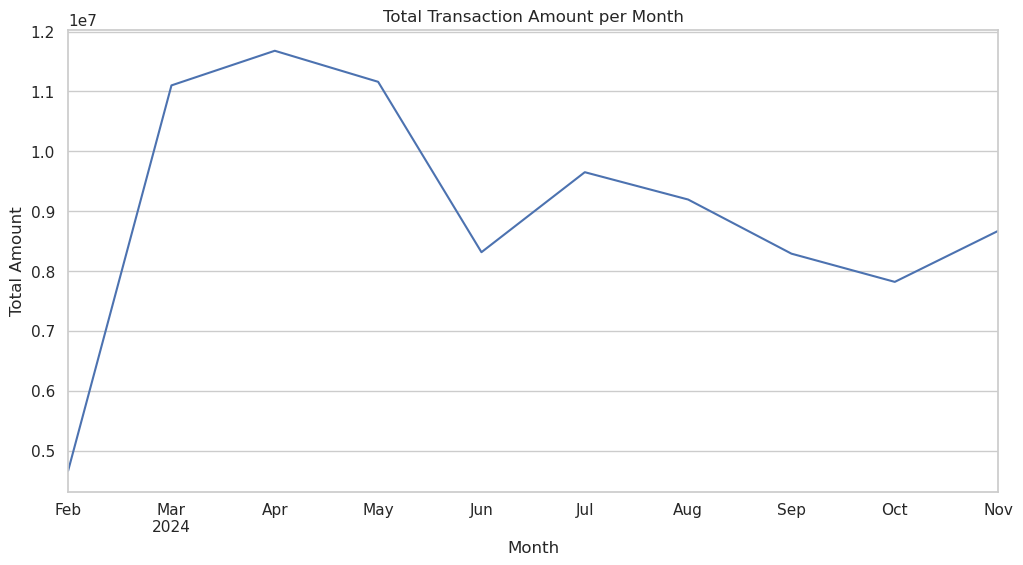

In [ ]:
monthly_amt = df.resample('M', on='deposit_dt')['item_amt'].sum()

monthly_amt.plot(figsize=(12, 6))
plt.title("Total Transaction Amount per Month")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.grid(True)
plt.show()

### channel

In [ ]:
print(df_53.loc[df_53['Field'] == 'channel', 'Definition'])
print(df['channel'].dtype)
print(df['channel'].isnull().mean() * 100)
print(df['channel'].agg(['min', 'max']))
print(df['channel'].is_unique)

10    Channel of deposit
Name: Definition, dtype: object
object
0.0
min    TELLER
max    TELLER
Name: channel, dtype: object
False


In [ ]:
df['channel'].is_unique

False

In [ ]:
df['channel'].value_counts()

channel
TELLER    17765
Name: count, dtype: int64

### relationship_balance
- This is the total balance for the customer for the prior day.

In [ ]:
definition = df_53.loc[df_53['Field'] == 'relationship_balance', 'Definition']
print(definition.values[0])

This is the total balance for the customer for the prior day.


In [ ]:
print(df['relationship_balance'].dtype)
print(df['relationship_balance'].isnull().mean() * 100)
print(df['relationship_balance'].agg(['min', 'max']))
print(df['relationship_balance'].is_unique)

int64
0.0
min     -99999999
max    2745575018
Name: relationship_balance, dtype: int64
False


In [ ]:
df['relationship_balance'].describe()

count    1.776500e+04
mean    -1.661621e+05
std      2.150990e+07
min     -1.000000e+08
25%      1.904000e+03
50%      1.012500e+04
75%      4.786900e+04
max      2.745575e+09
Name: relationship_balance, dtype: float64

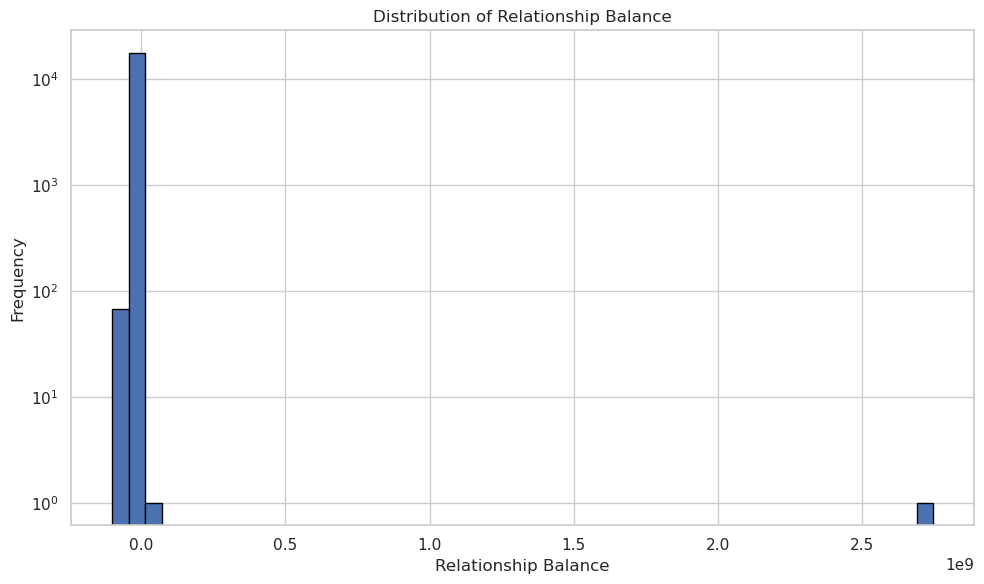

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['relationship_balance'], bins=50, edgecolor='black')
plt.title('Distribution of Relationship Balance')
plt.xlabel('Relationship Balance')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df[df['relationship_balance'] < 0]['relationship_balance']

29            -32
74      -99999999
80           -230
174           -21
254           -43
           ...   
17565         -11
17592         -19
17623        -285
17645   -99999999
17731   -99999999
Name: relationship_balance, Length: 169, dtype: int64

In [ ]:
df[df['relationship_balance'] < 0]['relationship_balance'] \
  .value_counts() \
  .sort_index(ascending=True)

relationship_balance
-99999999    68
-2144         1
-1926         1
-1540         1
-1412         1
             ..
-6            1
-4            3
-3            4
-2            3
-1            2
Name: count, Length: 76, dtype: int64

In [ ]:
df[df['relationship_balance'] > 0]['relationship_balance'] \
  .value_counts() \
  .sort_index(ascending=False)

relationship_balance
2745575018    1
18520601      1
9375121       1
6647064       1
6607629       1
             ..
5             7
4             2
3             5
2             7
1             7
Name: count, Length: 13398, dtype: int64

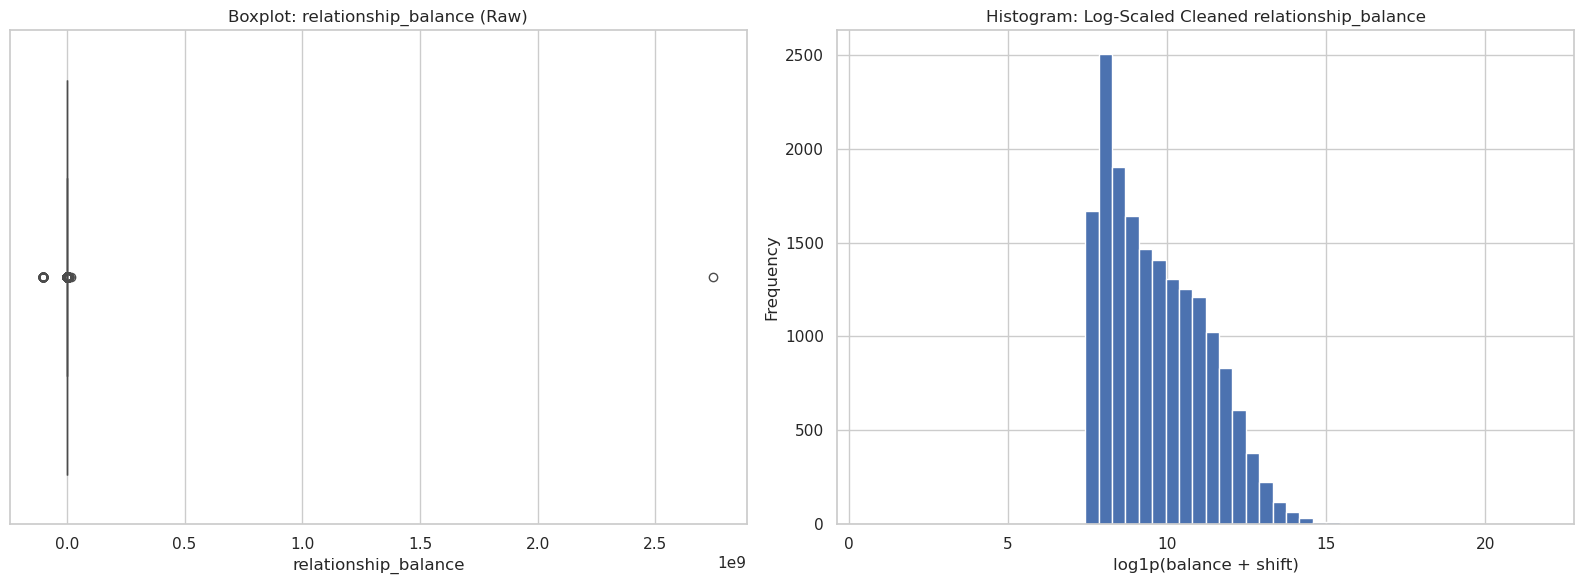

In [ ]:
balance_raw = df['relationship_balance'].dropna()

# Step 2: 删除系统标记值后的数据
balance_clean = df.loc[df['relationship_balance'] != -99999999, 'relationship_balance'].dropna()

# Step 3: 对清洗后的数据做 shift（确保 log 有效）+ log1p
min_val = balance_clean.min()
shift = 1 - min_val if min_val <= 0 else 0
balance_log = np.log1p(balance_clean + shift)

# 设置 1x2 图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x=balance_raw, ax=axes[0])
axes[0].set_title('Boxplot: relationship_balance (Raw)')
axes[0].set_xlabel('relationship_balance')

axes[1].hist(balance_log, bins=50)
axes[1].set_title('Histogram: Log-Scaled Cleaned relationship_balance')
axes[1].set_xlabel('log1p(balance + shift)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### oao_flg

In [ ]:
definition = df_53.loc[df_53['Field'] == 'oao_flg', 'Definition']
print(definition.values[0])

This flag indicates if the account was originated through the digital channel. 


In [ ]:
print(df_53.loc[df_53['Field'] == 'oao_flg', 'Definition'])
print(df['oao_flg'].dtype)
print(df['oao_flg'].isnull().mean() * 100)
print(df['oao_flg'].agg(['min', 'max']))
print(df['oao_flg'].is_unique)

12    This flag indicates if the account was origina...
Name: Definition, dtype: object
object
0.0
min    N
max    Y
Name: oao_flg, dtype: object
False


In [ ]:
df['oao_flg'].value_counts()

oao_flg
N    17527
Y      238
Name: count, dtype: int64

### onus_ind

In [ ]:
df['onus_ind'].value_counts()

onus_ind
F    14771
T     2994
Name: count, dtype: int64

In [ ]:
df['treasury_check_ind'].value_counts()

treasury_check_ind
N    17673
Y       92
Name: count, dtype: int64

In [ ]:
df['heloc_ind'].value_counts()

heloc_ind
N    17733
Y       32
Name: count, dtype: int64

### max_deposit_amount30d

In [ ]:
df[df['max_deposit_amount30d']<0]

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num


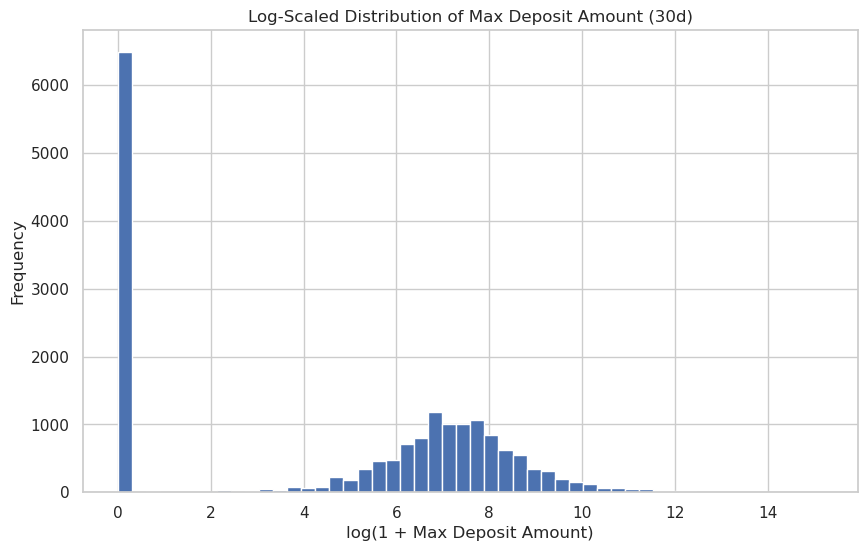

In [ ]:
valid_amt = df['max_deposit_amount30d']
valid_amt = valid_amt[valid_amt >= 0].dropna()

plt.figure(figsize=(10, 6))
plt.hist(np.log1p(valid_amt), bins=50)
plt.title('Log-Scaled Distribution of Max Deposit Amount (30d)')
plt.xlabel('log(1 + Max Deposit Amount)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
df['total_deposit_item_count'].describe()

count    17765.000000
mean         2.749282
std          9.137499
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        907.000000
Name: total_deposit_item_count, dtype: float64

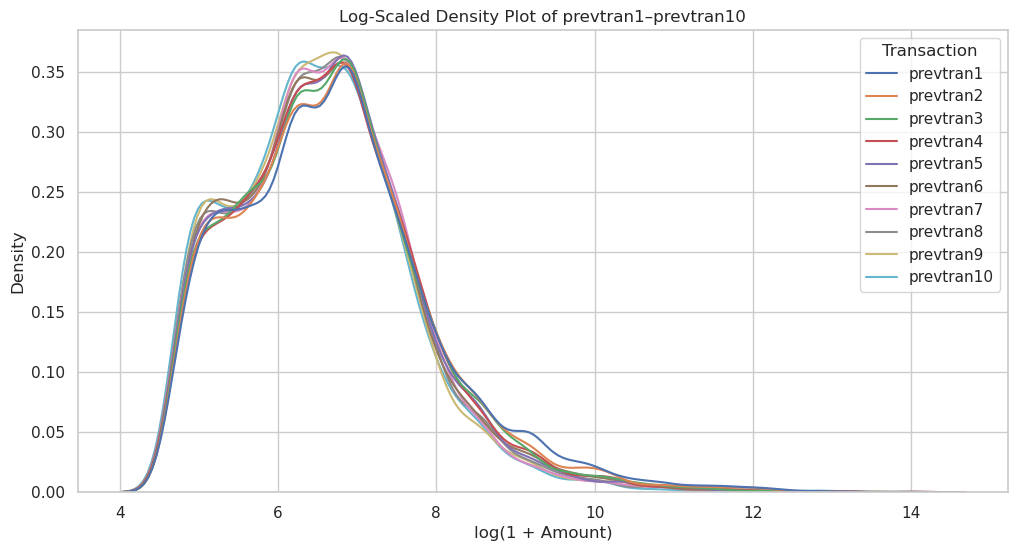

In [ ]:
prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
df_melted = df[prevtran_cols].melt(var_name='Transaction', value_name='Amount')

df_melted = df_melted[df_melted['Amount'].notna() & (df_melted['Amount'] >= 0)]

df_melted['Amount'] = np.log1p(df_melted['Amount'])

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_melted, x='Amount', hue='Transaction', common_norm=False)
plt.title('Log-Scaled Density Plot of prevtran1–prevtran10')
plt.xlabel('log(1 + Amount)')
plt.grid(True)
plt.show()

In [ ]:
prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]

for col in prevtrandate_cols:
    print(f"\n📌 Summary for {col}:")
    print(df[col].describe())


📌 Summary for prevtrandate1:
count    13378.000000
mean        20.985499
std         35.299715
min          0.000000
25%          0.000000
50%          7.000000
75%         28.000000
max        288.000000
Name: prevtrandate1, dtype: float64

📌 Summary for prevtrandate2:
count    11152.000000
mean        32.969064
std         40.883736
min          0.000000
25%          7.000000
50%         21.000000
75%         42.250000
max        287.000000
Name: prevtrandate2, dtype: float64

📌 Summary for prevtrandate3:
count    9678.000000
mean       42.309051
std        44.726538
min         0.000000
25%        13.000000
50%        28.000000
75%        59.000000
max       284.000000
Name: prevtrandate3, dtype: float64

📌 Summary for prevtrandate4:
count    8654.000000
mean       50.757684
std        47.810591
min         0.000000
25%        19.000000
50%        35.000000
75%        69.000000
max       290.000000
Name: prevtrandate4, dtype: float64

📌 Summary for prevtrandate5:
count    7736.0000

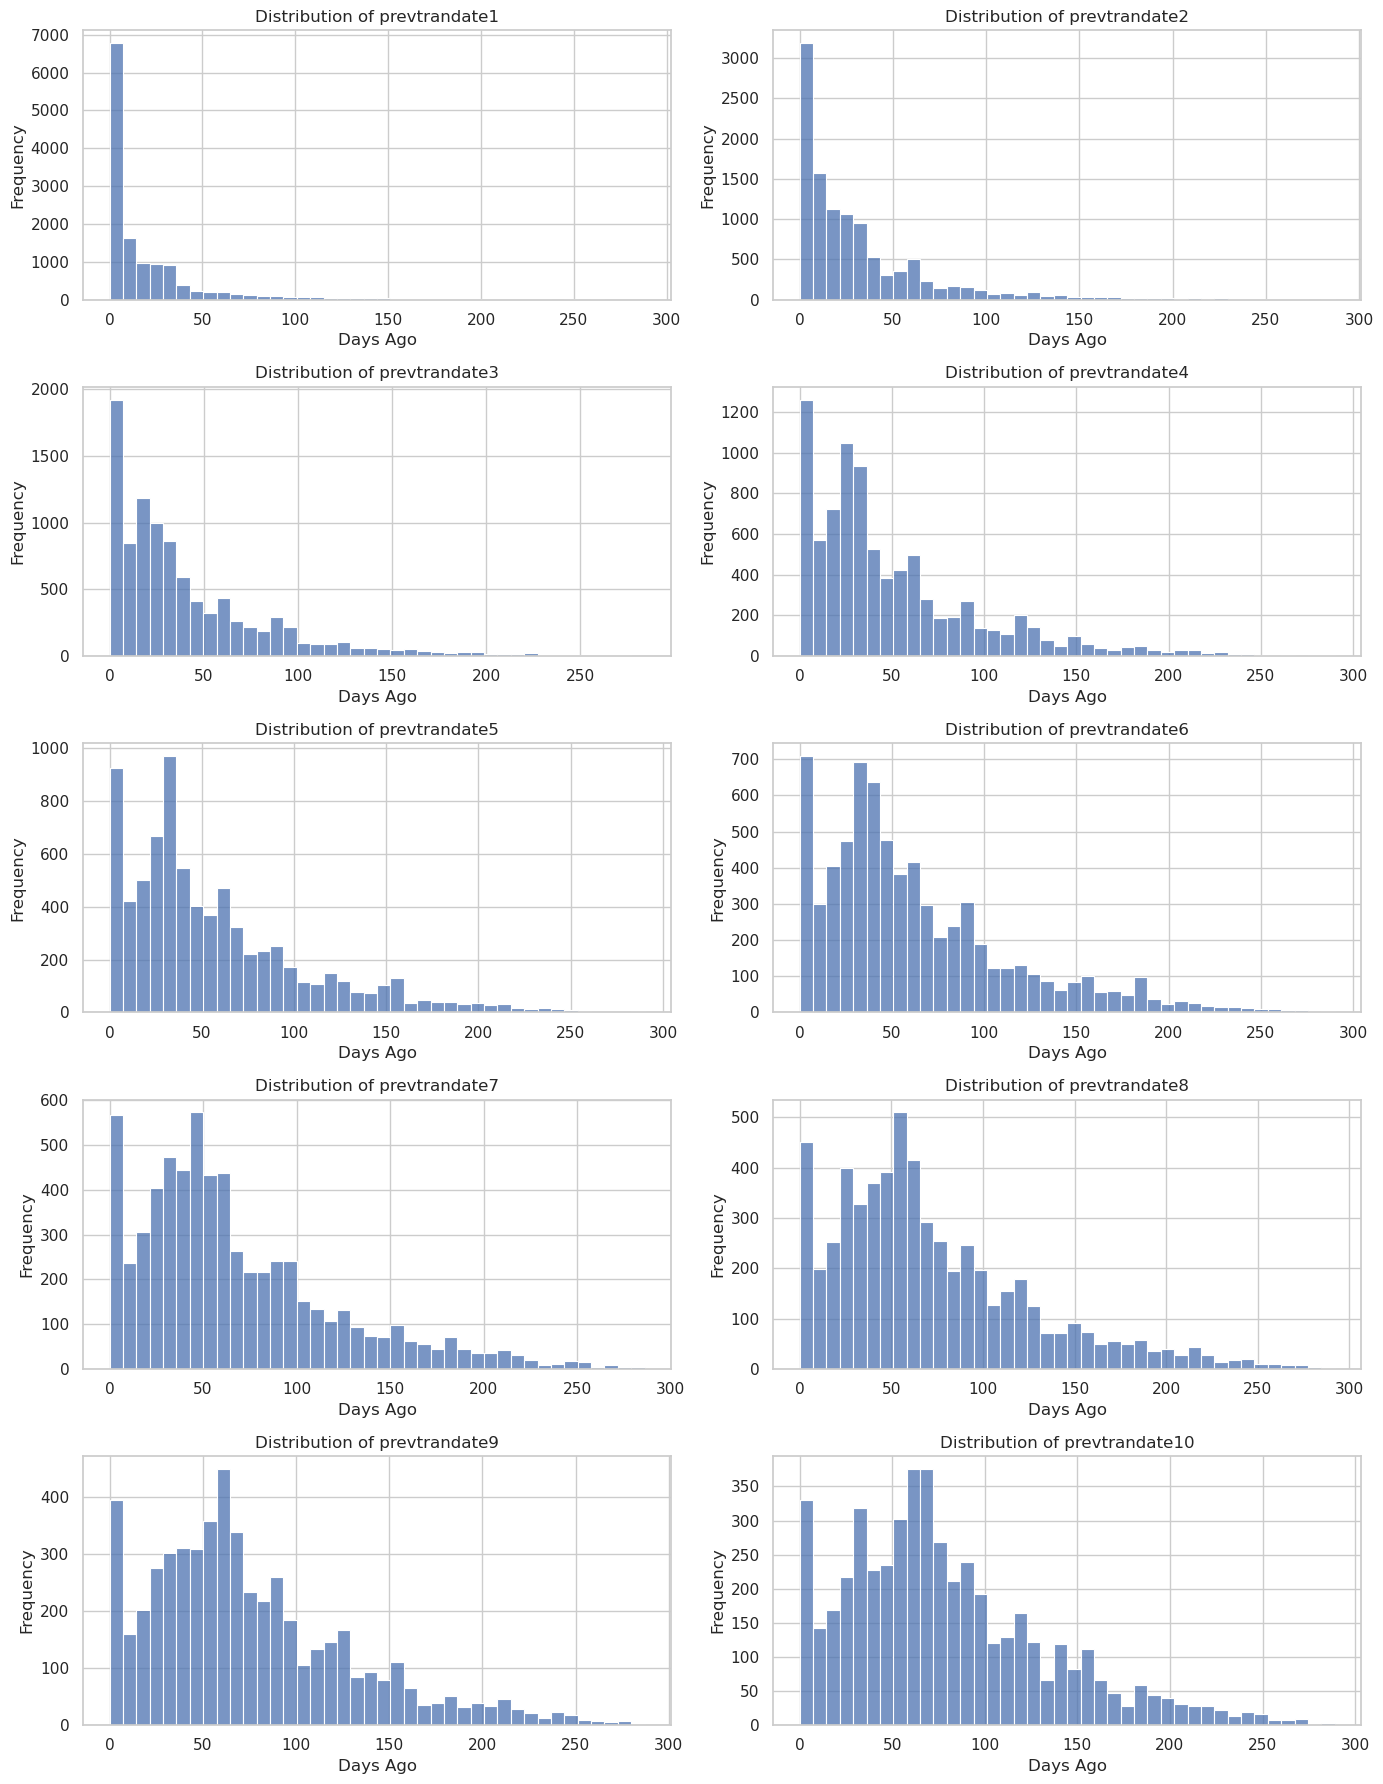

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18))
axes = axes.flatten()

for i, col in enumerate(prevtrandate_cols):
    sns.histplot(df[col].dropna(), bins=40, ax=axes[i], kde=False)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Days Ago')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

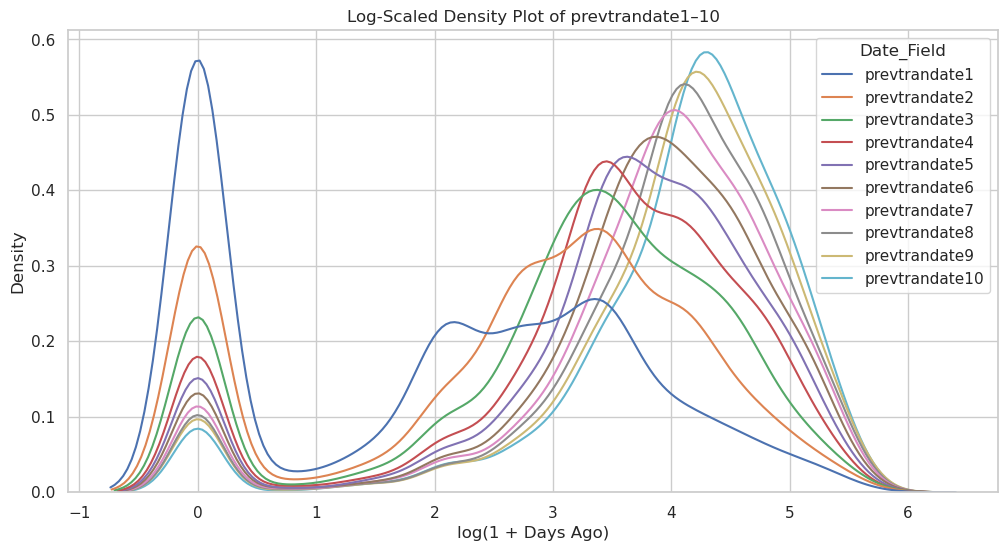

In [ ]:
prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
df_melted = df[prevtrandate_cols].melt(var_name='Date_Field', value_name='Days_Ago')

df_melted = df_melted[df_melted['Days_Ago'].notna() & (df_melted['Days_Ago'] >= 0)]

df_melted['Days_Ago'] = np.log1p(df_melted['Days_Ago'])

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_melted, x='Days_Ago', hue='Date_Field', common_norm=False)
plt.title('Log-Scaled Density Plot of prevtrandate1–10')
plt.xlabel('log(1 + Days Ago)')
plt.grid(True)
plt.show()

### drawee_sum

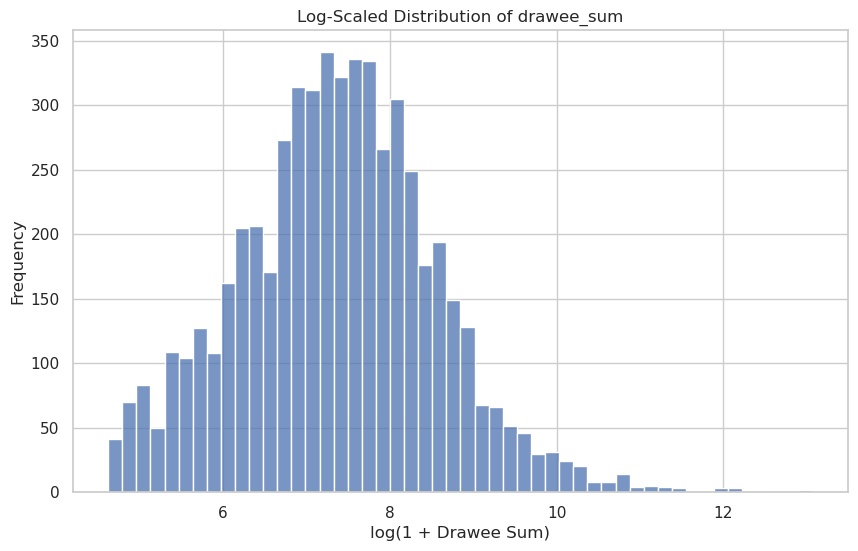

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['drawee_sum']), bins=50)
plt.title('Log-Scaled Distribution of drawee_sum')
plt.xlabel('log(1 + Drawee Sum)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### drawee_cnt                     

In [ ]:
df['drawee_cnt'].describe()

count    5529.000000
mean        2.415808
std         2.807469
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       135.000000
Name: drawee_cnt, dtype: float64

### drawee_avg

In [ ]:
df['drawee_avg'].describe()

count      5529.000000
mean       2024.017385
std       10034.703251
min         101.000000
25%         419.630000
50%         827.200000
75%        1543.120000
max      475000.000000
Name: drawee_avg, dtype: float64

### drawee_max

In [ ]:
df['drawee_max'].describe()

count      5529.000000
mean       2329.367850
std       11639.477385
min         101.000000
25%         454.290000
50%         902.810000
75%        1695.770000
max      475000.000000
Name: drawee_max, dtype: float64

### drawee_min

In [ ]:
df['drawee_min'].describe()

count      5529.000000
mean       1826.872344
std        9845.245735
min         100.200000
25%         346.230000
50%         727.100000
75%        1400.000000
max      475000.000000
Name: drawee_min, dtype: float64

### RDI_DT

<Axes: title={'center': 'RDI_DT Frequency Over Time'}, xlabel='RDI_DT'>

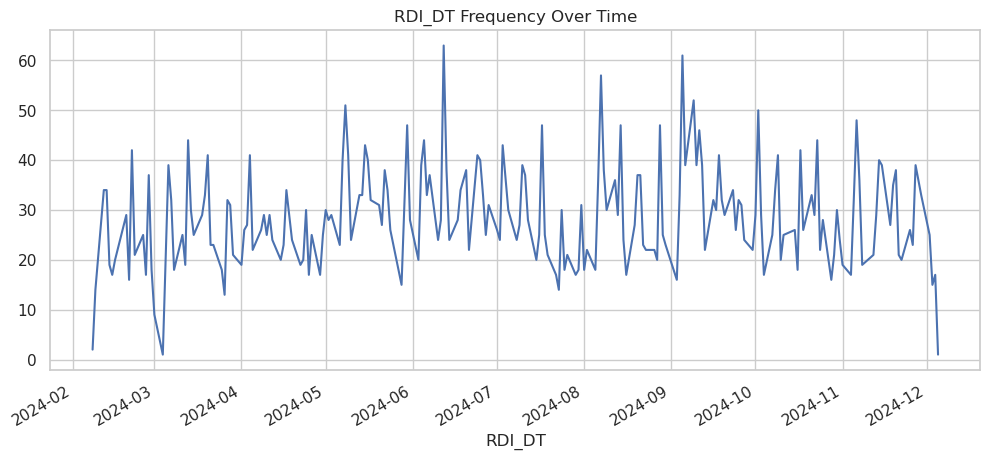

In [ ]:
df['RDI_DT'] = pd.to_datetime(df['RDI_DT'], errors='coerce')
df['RDI_DT'].value_counts().sort_index().plot(figsize=(12, 5), title='RDI_DT Frequency Over Time')


### 


In [ ]:
df['RETURN_REASON'].value_counts()

RETURN_REASON
1.0     3201
10.0    1110
6.0      801
16.0     293
9.0      152
2.0      113
34.0     110
12.0      82
11.0      36
25.0      27
28.0       5
29.0       5
14.0       4
33.0       4
27.0       3
8.0        2
19.0       1
31.0       1
7.0        1
38.0       1
26.0       1
32.0       1
Name: count, dtype: int64

<Axes: title={'center': 'Return Reason Distribution'}, xlabel='RETURN_REASON'>

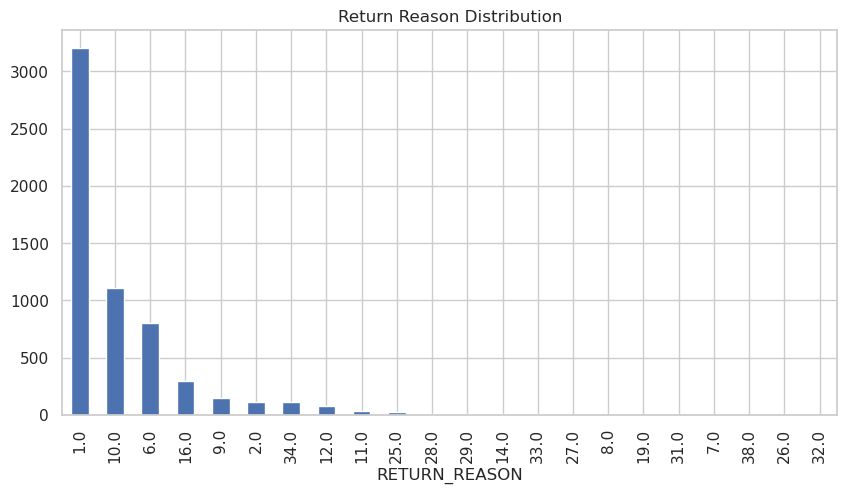

In [ ]:
df['RETURN_REASON'].value_counts().plot(kind='bar', figsize=(10, 5), title='Return Reason Distribution')

### return_target

<Axes: title={'center': 'Return Target Distribution'}, xlabel='return_target'>

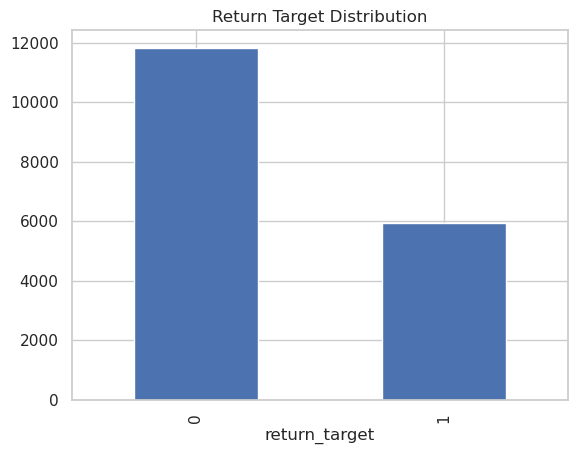

In [ ]:
df['return_target'].value_counts().plot(kind='bar', title='Return Target Distribution')

In [ ]:
df['over_draft_amount'].value_counts()

over_draft_amount
0     16669
1       390
2       208
3       100
4        69
5        64
7        37
6        34
8        27
9        23
12       21
10       20
17       13
15       13
11       13
14       10
13       10
21        9
19        9
18        7
20        7
16        7
22        5
Name: count, dtype: int64

<Axes: xlabel='over_draft_amount', ylabel='Count'>

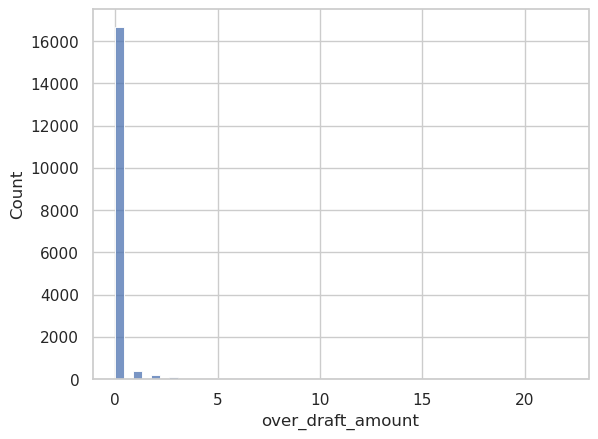

In [ ]:
sns.histplot(df['over_draft_amount'], bins=50)

<Axes: title={'center': 'Monthly Activity Count'}, xlabel='month_num'>

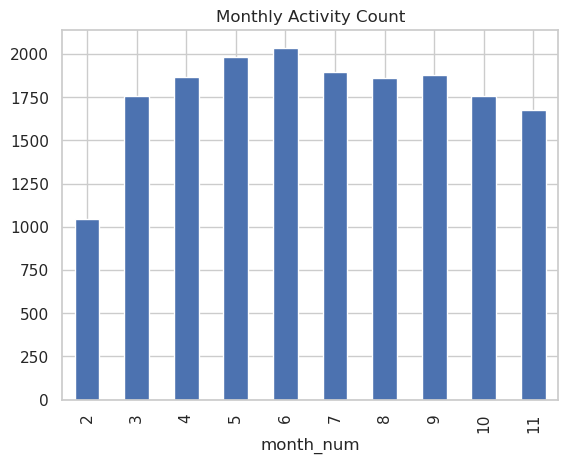

In [ ]:
df['month_num'].value_counts().sort_index().plot(kind='bar', title='Monthly Activity Count')


# FE

In [ ]:
df = df.copy()

## Drop it

`masked_dep_acct_num` – All values are unique → no predictive power

`masked_id` – All values are unique → behaves like an ID column

`channel` – Only one unique value → no variance


In [ ]:
# Drop features with no predictive power or variance
cols_to_drop = ['masked_dep_acct_num', 'masked_id', 'channel']
df = df.drop(columns=cols_to_drop)

In [ ]:
df

,masked_bank_num,masked_account_type,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,relationship_balance,oao_flg,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,5000+,1,517.81,517.81,2024-08-01,160872,N,...,1882.21,4.0,470.5525,535.92,400.77,NaT,NaN,0,0,8
1,0,0,1,0-1000,1,150.00,150.00,2024-04-25,485,N,...,150.00,1.0,150.0000,150.00,150.00,NaT,NaN,0,0,4
2,0,0,0,5000+,0,2603.24,2451.00,2024-03-18,27059,N,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0,0,3
3,0,0,1,5000+,0,770.00,770.00,2024-11-29,2107,N,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0,0,11
4,0,0,1,2000-5000,2,10776.63,145.00,2024-05-29,4916,N,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaT,NaN,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17760,6,0,0,5000+,2,2000.00,2000.00,2024-11-05,2094,N,...,NaN,NaN,NaN,NaN,NaN,2024-11-06,1.0,1,0,11
17761,0,0,1,0-1000,1,5000.00,5000.00,2024-11-06,2612,N,...,NaN,NaN,NaN,NaN,NaN,2024-11-08,1.0,1,0,11
17762,0,1,17,5000+,0,4000.00,2000.00,2024-11-12,480820,N,...,NaN,NaN,NaN,NaN,NaN,2024-11-14,1.0,1,0,11
17763,0,0,1,5000+,0,3000.00,3000.00,2024-11-18,1533,N,...,NaN,NaN,NaN,NaN,NaN,2024-11-20,1.0,1,0,11


## One-hot

`masked_bank_num`: Despite the imbalance, we apply one-hot encoding to preserve all categories in masked_bank_num.

`masked_account_type`: represents different masked account types, originally mapped to integers [0–4]. Since the values are categorical (not ordinal), we apply one-hot encoding to capture type distinctions without implying any order.


`masked_product_code`: contains many categories with highly imbalanced sample sizes. To reduce noise and sparsity while preserving useful signal, we group rare categories into "Other" and apply one-hot encoding to the top 8 most frequent codes. This balances interpretability, model stability, and predictive power.

In [ ]:
top_n = 8
top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index

df['masked_product_code_grouped'] = df['masked_product_code'].apply(
    lambda x: f'prod_{x}' if x in top_product_codes else 'Other'
)

In [ ]:
one_hot_features = ['masked_bank_num', 'masked_account_type', 'masked_product_code_grouped']
df = pd.get_dummies(df, columns=one_hot_features)

## Ordinal Encoding

`bucket_days_since_open`: represents account age in ordinal bins. We encode it with increasing integers to preserve the inherent order, and impute missing values with -1 to indicate absence without breaking ordinal semantics.

number_of_owners is a numeric feature that represents the count of owners on the account. Since it is ordinal and has meaningful magnitude, we keep it as a raw numerical input. No encoding is required.

In [ ]:
df['bucket_days_since_open'] = df['bucket_days_since_open'].fillna(-1)

ordinal_mapping = {
    '0-1000': 0,
    '1000-2000': 1,
    '2000-5000': 2,
    '5000+': 3
}
df['bucket_days_since_open'] = df['bucket_days_since_open'].map(ordinal_mapping)

## Log

total_deposit_amount feature is heavily right-skewed with extreme outliers. We apply a log1p transformation to normalize the distribution and reduce outlier impact. 

Since this feature will be used in both GLM and tree-based models, we apply a log1p transformation followed by RobustScaler. This ensures that the feature is normalized for GLM while maintaining robustness and predictive value for tree models.

relationship_balance： The special system flag -99,999,999 is isolated into a binary indicator relationship_balance_new_account. The remaining values are filled with the median and log-transformed (with a shift for negatives), resulting in relationship_balance_log, which is ready for modeling.



In [ ]:
### -------- total_deposit_amount -------- ###
# Step 1: log1p transform
df['total_deposit_amount_log'] = np.log1p(df['total_deposit_amount'])

# Step 2: RobustScaler
robust_scaler_total = RobustScaler()
df['total_deposit_amount_log_scaled'] = robust_scaler_total.fit_transform(
    df[['total_deposit_amount_log']]
)

### -------- item_amt -------- ###
# Step 1: log1p transform
df['item_amt_log'] = np.log1p(df['item_amt'])

# Step 2: RobustScaler
robust_scaler_item = RobustScaler()
df['item_amt_log_scaled'] = robust_scaler_item.fit_transform(
    df[['item_amt_log']]
)

In [ ]:
scaled = df['item_amt_log_scaled'].dropna()

print("Median:", np.median(scaled))
print("IQR:", np.percentile(scaled, 75) - np.percentile(scaled, 25))


Median: 0.0
IQR: 1.0


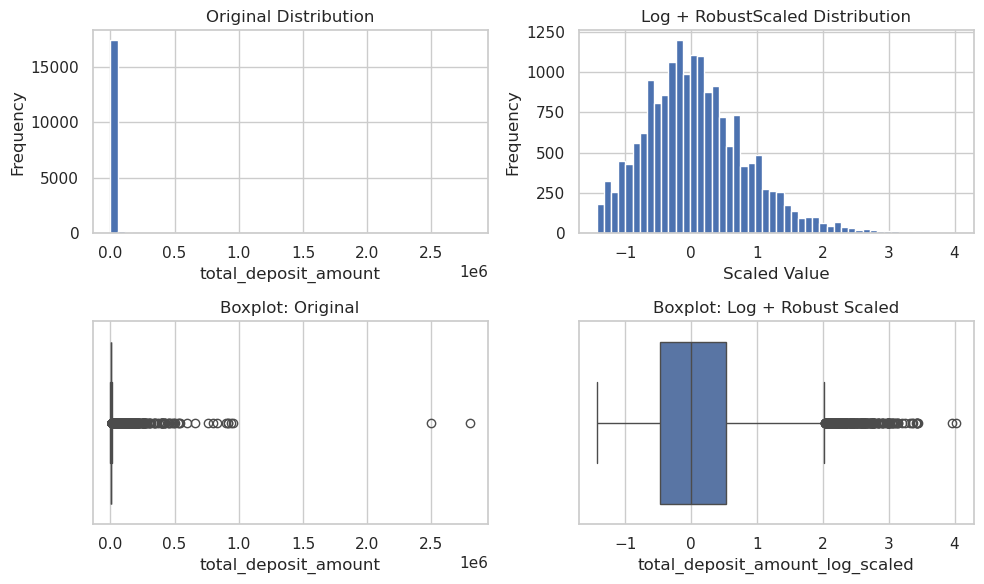

In [ ]:
sns.set(style="whitegrid")

dep_raw = df['total_deposit_amount'].dropna()
dep_log_scaled = df['total_deposit_amount_log_scaled'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].hist(dep_raw, bins=50)
axes[0, 0].set_title('Original Distribution')
axes[0, 0].set_xlabel('total_deposit_amount')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(dep_log_scaled, bins=50)
axes[0, 1].set_title('Log + RobustScaled Distribution')
axes[0, 1].set_xlabel('Scaled Value')
axes[0, 1].set_ylabel('Frequency')

sns.boxplot(x=dep_raw, ax=axes[1, 0])
axes[1, 0].set_title('Boxplot: Original')

sns.boxplot(x=dep_log_scaled, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot: Log + Robust Scaled')

plt.tight_layout()
plt.show()

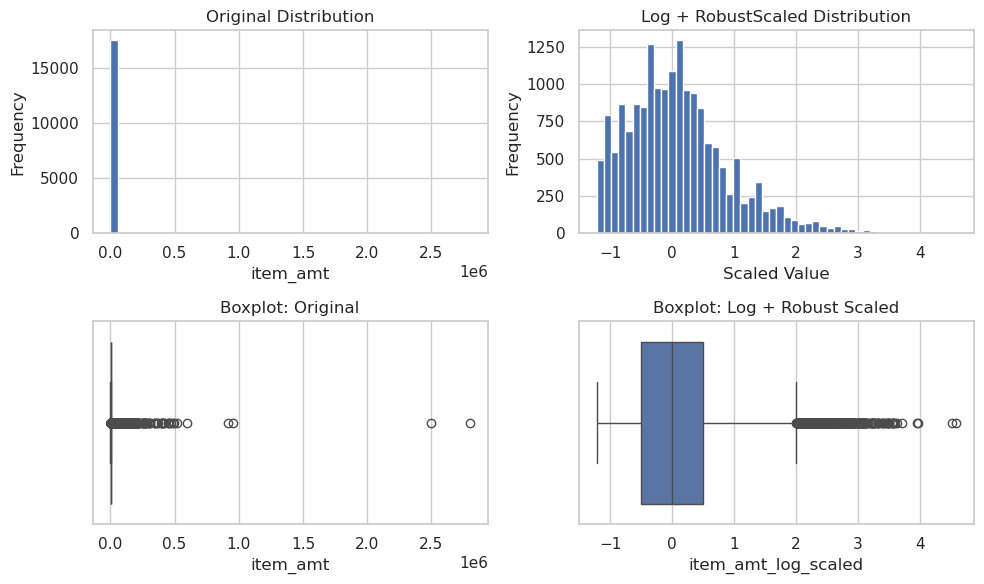

In [ ]:
sns.set(style="whitegrid")

item_raw = df['item_amt'].dropna()
item_log_scaled = df['item_amt_log_scaled'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].hist(item_raw, bins=50)
axes[0, 0].set_title('Original Distribution')
axes[0, 0].set_xlabel('item_amt')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(item_log_scaled, bins=50)
axes[0, 1].set_title('Log + RobustScaled Distribution')
axes[0, 1].set_xlabel('Scaled Value')
axes[0, 1].set_ylabel('Frequency')
sns.boxplot(x=item_raw, ax=axes[1, 0])
axes[1, 0].set_title('Boxplot: Original')

sns.boxplot(x=item_log_scaled, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot: Log + Robust Scaled')

plt.tight_layout()
plt.show()

In [ ]:
row_extreme_balance = df[df['relationship_balance'] == 2745575018]
print(row_extreme_balance)

      masked_dep_acct_num  masked_bank_num  masked_account_type  masked_id  \
4196                 9360                0                    0      10900   

      masked_product_code bucket_days_since_open  number_of_owners  \
4196                    3                  5000+                 4   

      total_deposit_amount  item_amt  deposit_dt  ... drawee_sum  drawee_cnt  \
4196             762995.29    886.12  2024-04-22  ...     886.12         1.0   

     drawee_avg drawee_max drawee_min RDI_DT  RETURN_REASON  return_target  \
4196     886.12     886.12     886.12    NaN            NaN              0   

      over_draft_amount  month_num  
4196                  1          4  

[1 rows x 49 columns]


      masked_dep_acct_num  masked_bank_num  masked_account_type  masked_id  masked_product_code bucket_days_since_open  number_of_owners  total_deposit_amount  item_amt  deposit_dt channel  relationship_balance oao_flg onus_ind treasury_check_ind heloc_ind  rdis  max_deposit_amount30d  total_deposit_item_count  prevtran1  prevtran2  prevtran3  prevtran4  prevtran5  prevtran6  prevtran7  prevtran8  prevtran9  prevtran10  prevtrandate1  prevtrandate2  prevtrandate3  prevtrandate4  prevtrandate5  prevtrandate6  prevtrandate7  prevtrandate8  prevtrandate9  prevtrandate10  drawee_sum  drawee_cnt  drawee_avg  drawee_max  drawee_min RDI_DT  RETURN_REASON  return_target  over_draft_amount  month_num
4196                 9360                0                    0      10900                    3                  5000+                 4             762995.29    886.12  2024-04-22  TELLER            2745575018       N        F                  N         N   NaN             3905799.42              

In [ ]:
df['relationship_balance_new_account'] = (df['relationship_balance'] == -99999999).astype(int)

df['relationship_balance_clean'] = df['relationship_balance'].replace(-99999999, np.nan)

median_val = df['relationship_balance_clean'].median()
df['relationship_balance_clean'] = df['relationship_balance_clean'].fillna(median_val)

min_val = df['relationship_balance_clean'].min()
shift = 1 - min_val if min_val <= 0 else 0

df['relationship_balance_log'] = np.log1p(df['relationship_balance_clean'] + shift)

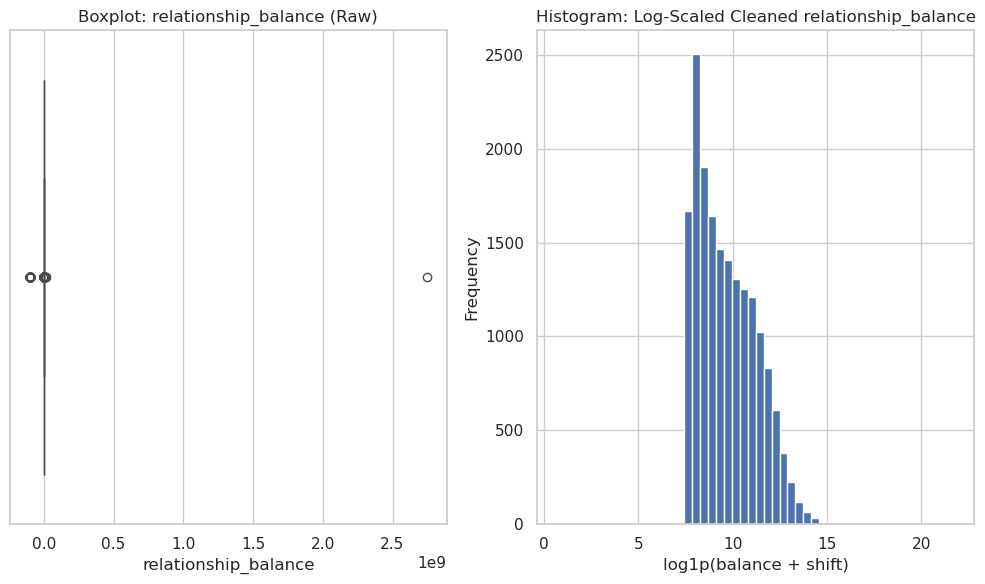

In [ ]:
balance_raw = df['relationship_balance'].dropna()

balance_clean = df.loc[df['relationship_balance'] != -99999999, 'relationship_balance'].dropna()

min_val = balance_clean.min()
shift = 1 - min_val if min_val <= 0 else 0
balance_log = np.log1p(balance_clean + shift)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))


sns.boxplot(x=balance_raw, ax=axes[0])
axes[0].set_title('Boxplot: relationship_balance (Raw)')
axes[0].set_xlabel('relationship_balance')

axes[1].hist(balance_log, bins=50)
axes[1].set_title('Histogram: Log-Scaled Cleaned relationship_balance')
axes[1].set_xlabel('log1p(balance + shift)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Date

deposit_dt：We extract the quarter and day of the week from the deposit_dt timestamp to capture temporal transaction patterns. 

In [ ]:
df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])

df['deposit_quarter'] = df['deposit_dt'].dt.quarter
df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek

In [ ]:
ordinal_features = ['deposit_quarter', 'deposit_dayofweek']

## Binary Encoding

`oao_flg` variable is a binary categorical flag. We convert it into a numeric 0/1 encoding (oao_flg_binary) to make it directly usable by both GLMs and tree-based models.

In [ ]:
df['oao_flg_binary'] = (df['oao_flg'] == 'Y').astype(int)
df.rename(columns={'oao_flg': 'oao_flg_binary'}, inplace=True)